In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm




/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [17]:
transform =torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomRotation(degrees=(-30,30)),
    torchvision.transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


dataset=torchvision.datasets.ImageFolder('./data/',transform=transform)


train_size=int(0.7*len(dataset))
test_size=len(dataset)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size,test_size])


trainloader=torch.utils.data.DataLoader(train_dataset,batch_size=512,shuffle=True,num_workers=2)
testloader=torch.utils.data.DataLoader(test_dataset,batch_size=512,shuffle=True,num_workers=2)



In [18]:
len(dataset)

1462

In [19]:
dataset.classes

['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

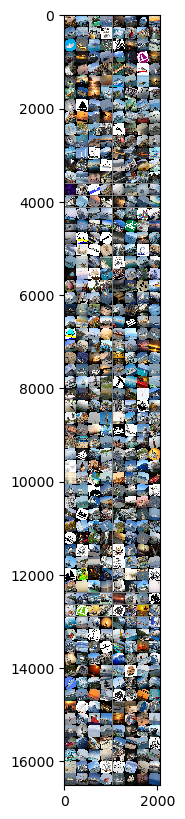

In [20]:
def imshow(img):
    plt.figure(figsize=(10,10))
    img=img/2 + 0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


dataiter =iter(trainloader)
images,labels =next(dataiter)
imshow(torchvision.utils.make_grid(images))



In [21]:
 net = torchvision.models.resnet152(weights=True)

In [22]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
for param in net.parameters():
    param.requires_grad=False

In [24]:
net.fc=nn.Linear(2048,9)

In [25]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
net=net.cuda()

In [27]:
net(images.cuda()).shape

torch.Size([512, 9])

In [28]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=0.01)

In [29]:
 def get_quality(net):
     correct=0
     total=0
     with torch.no_grad():
         for data in testloader:
             images,labels=data
             images,labels=images.cuda(),labels.cuda()
             outputs=net(images)
             _,predicted=torch.max(outputs.data,1)
             total+=labels.size(0)
             correct+=(predicted==labels).sum().item()
     print('accuracy of the network on test images: %d %%' %(100*correct/total))


def train_network(net,n_epochs=10):
    losses=[]
    for epoch in range(n_epochs):
        running_loss=0.0
        for i,data in enumerate(tqdm(trainloader)):
            images,labels=data
            images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            outputs=net(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            losses.append(loss.item())
    print('[%d,%d] loss: %.3f'%(epoch+1,i+1,running_loss/2000))
    running_loss=0.0
    get_quality(net)
    plt.plot(losses,'b')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    print('Finish Training')

In [ ]:
train_network(net,n_epochs=100)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

In [ ]:
from tqdm import tqdm
from time import sleep
 
 
for i in tqdm(range(0, 100), 
              ascii ="123456789$#", unit =" time"):
    sleep(.200)